In [40]:
!pip install sweetviz

id: Unique identifier for each patient (numerical).

age: Age of the patient in years (numerical).

dataset: Place of study or origin (categorical).
Cleveland
Hungary
Switzerland
VA Long Beach

sex: Gender of the patient (categorical: Male/Female).

cp: Chest pain type (categorical):
Typical angina
Atypical angina
Non-anginal pain
Asymptomatic
trestbps: Resting blood pressure (numerical, in mm Hg).

chol: Serum cholesterol level in mg/dl (numerical).

fbs: Fasting blood sugar > 120 mg/dl (Boolean: True/False).

restecg: Resting electrocardiographic results (categorical):

Normal
ST-T wave abnormality
Left ventricular hypertrophy
thalach: Maximum heart rate achieved during exercise (numerical).
exang: Exercise-induced angina (Boolean: True/False).

oldpeak: ST depression induced by exercise relative to rest (numerical).

slope: The slope of the peak exercise ST segment (categorical).

downsloping
flat
upsloping
ca: Number of major vessels colored by fluoroscopy (numerical, range 0-3).

thal: Thalassemia (categorical):

Normal
Fixed defect
Reversible defect
num: Predicted attribute (target variable, numerical).

In [61]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sweetviz as sv
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, classification_report, precision_score, f1_score

In [56]:
heart = pd.read_csv("/kaggle/input/heart-disease-data/heart_disease_uci.csv")
heart=heart.rename(columns={'num':'target', 'dataset':'origin','fbs':'fast_blood_sugar','cp':'chest_pain_type'})
print(heart.shape)



(920, 16)


                                             |          | [  0%]   00:00 -> (? left)


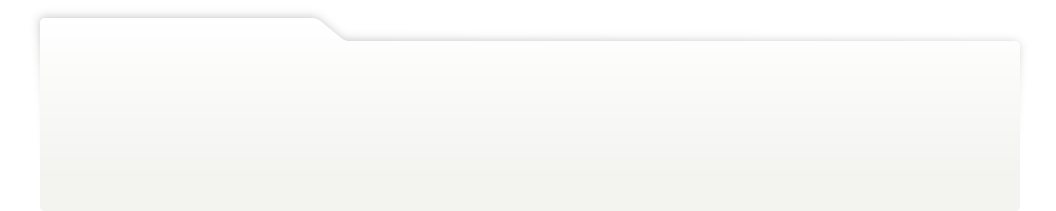
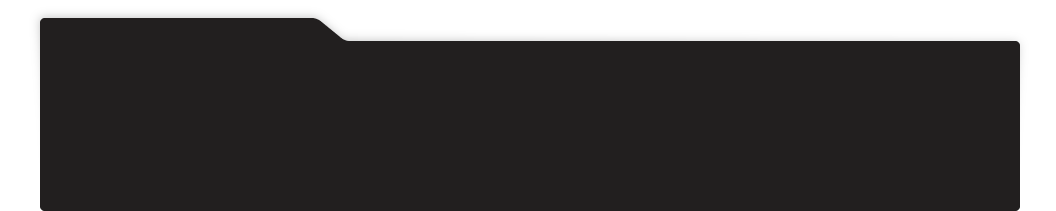
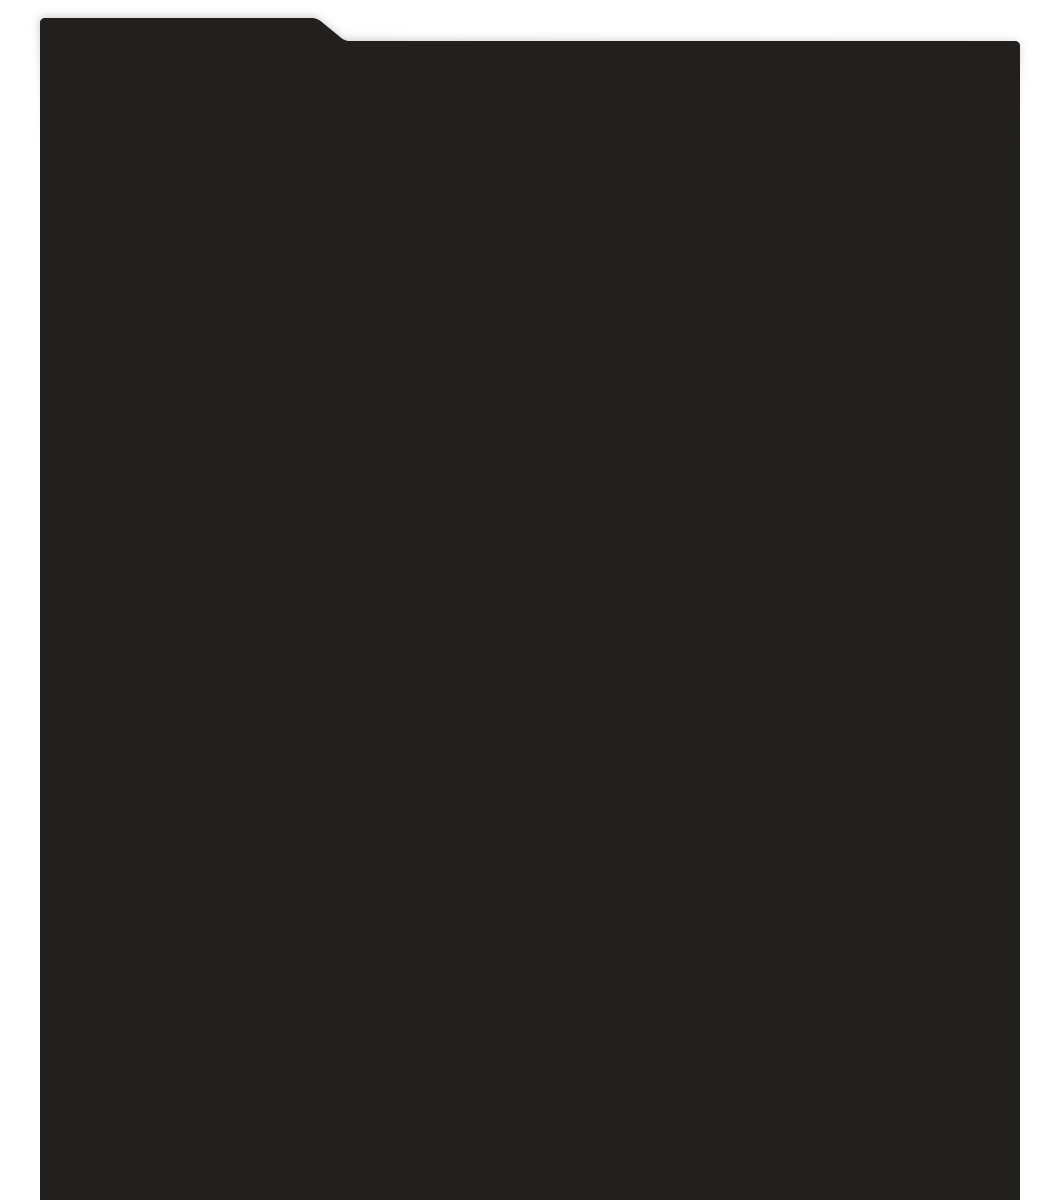
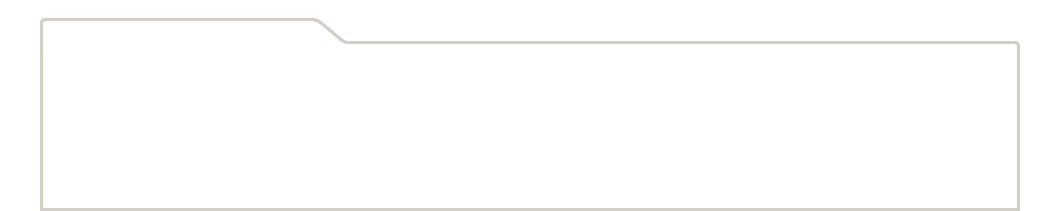
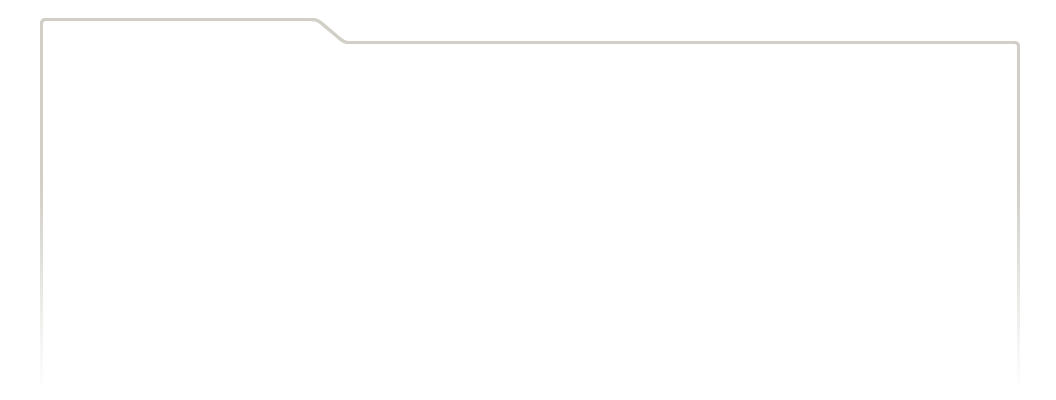
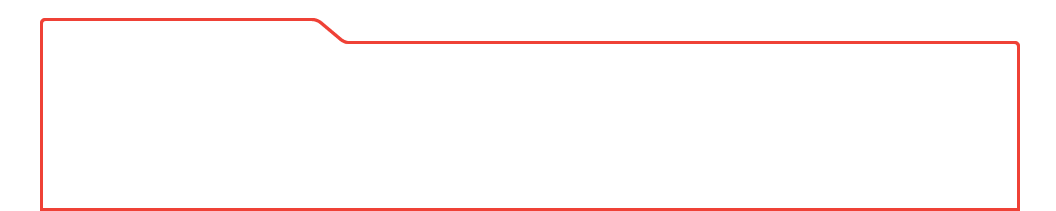
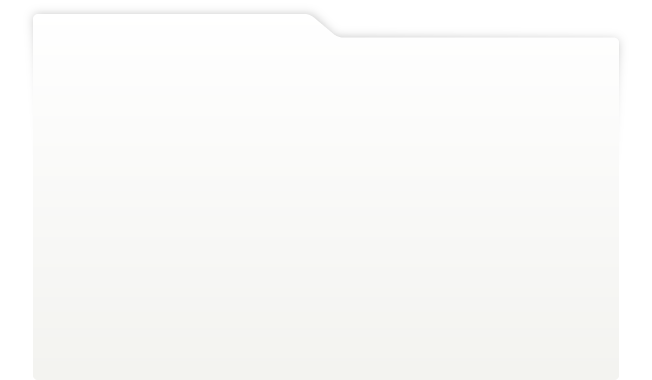
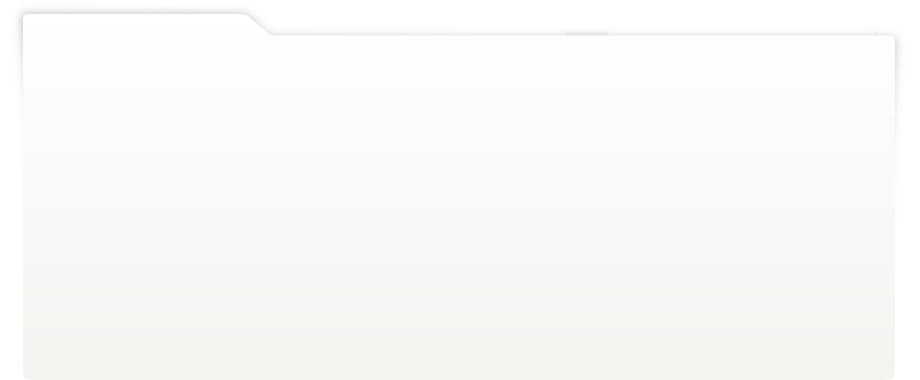
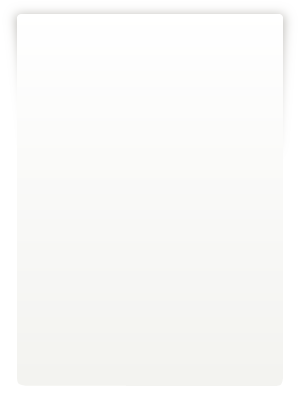
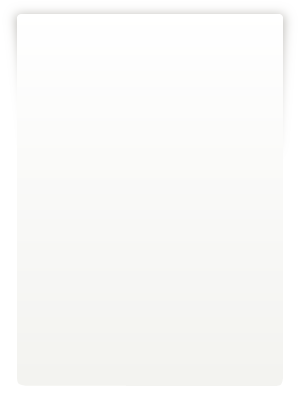
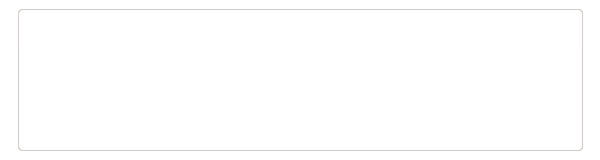
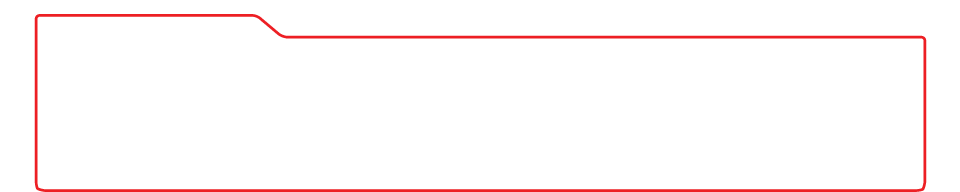
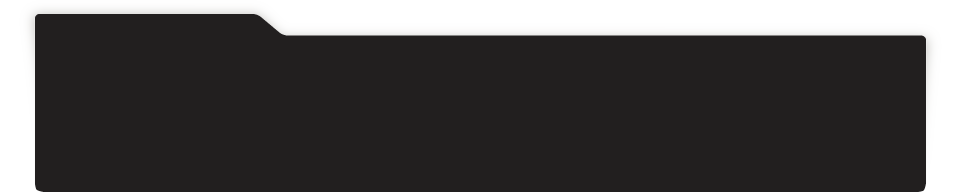
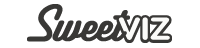
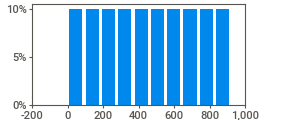
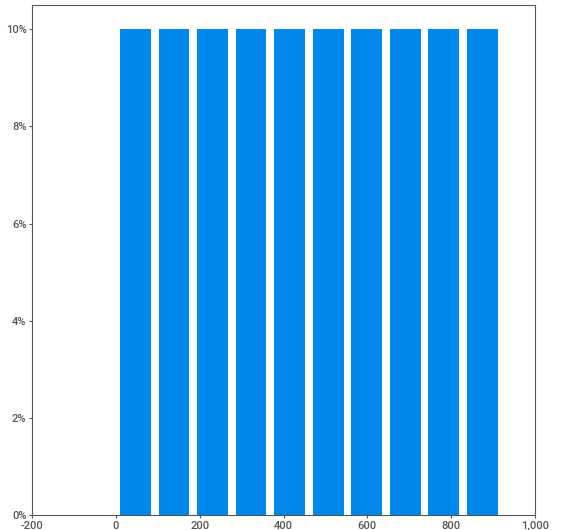
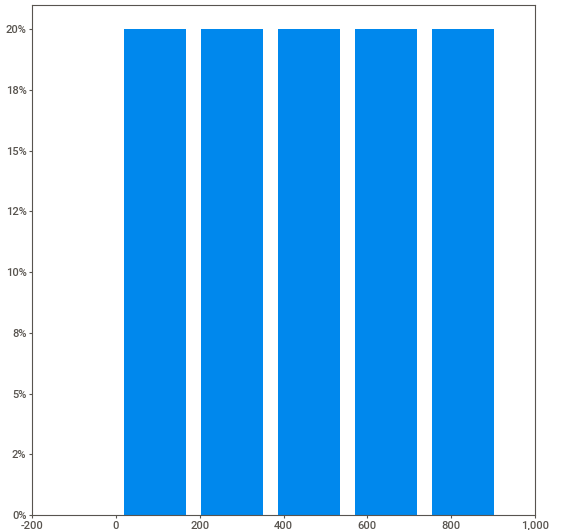
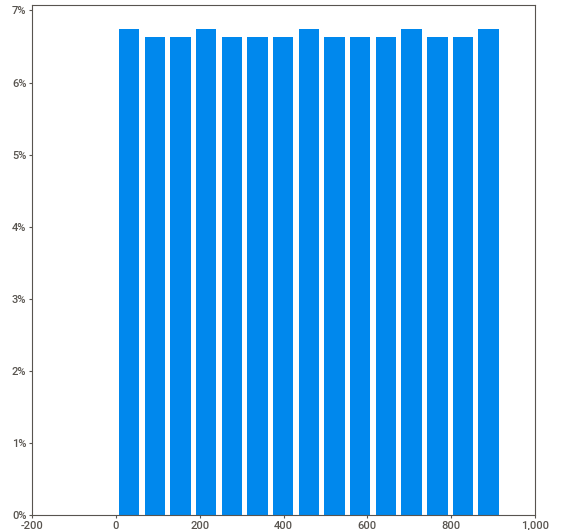
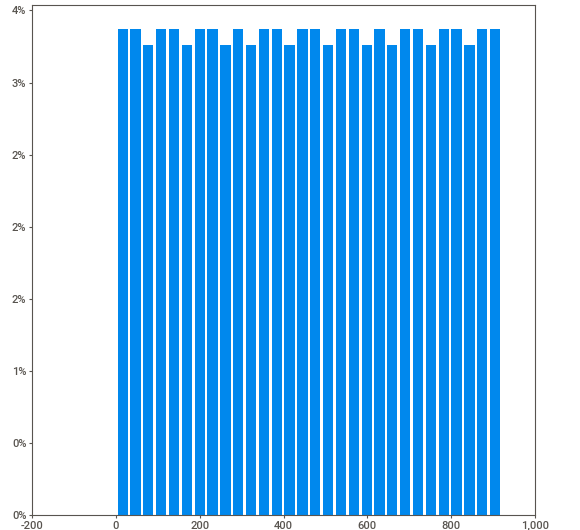
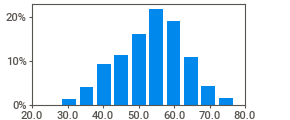
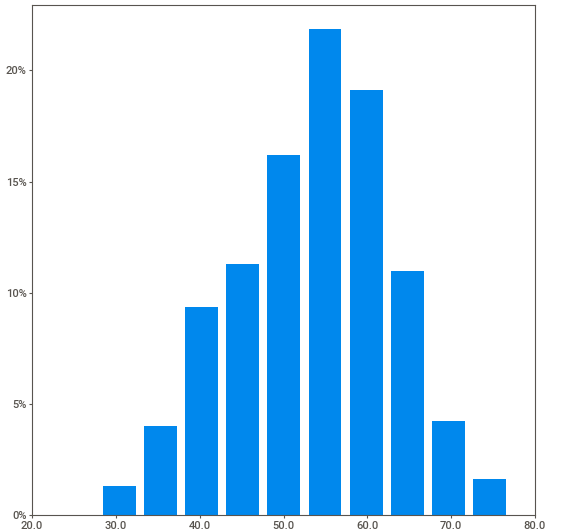
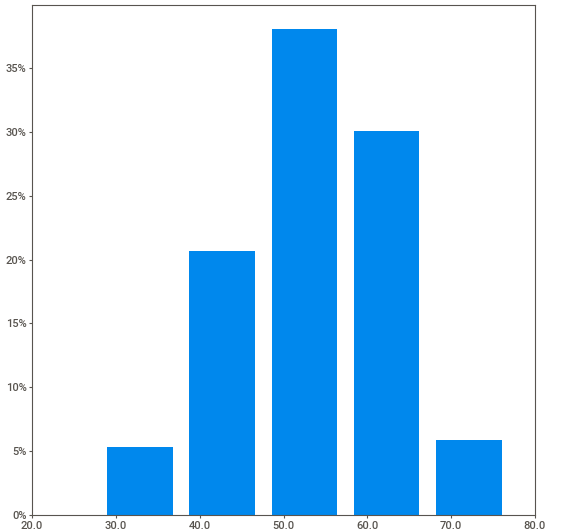
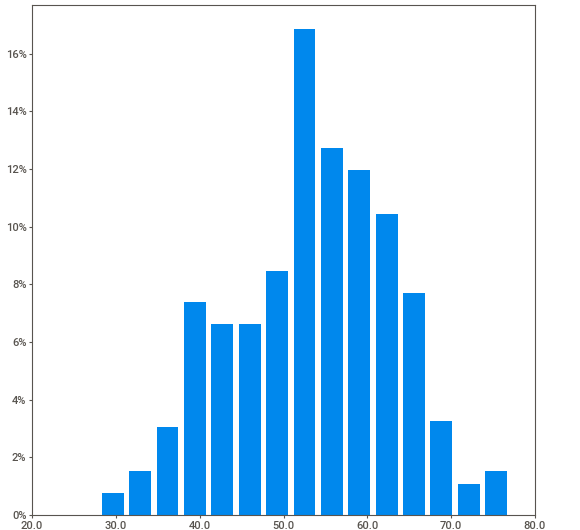
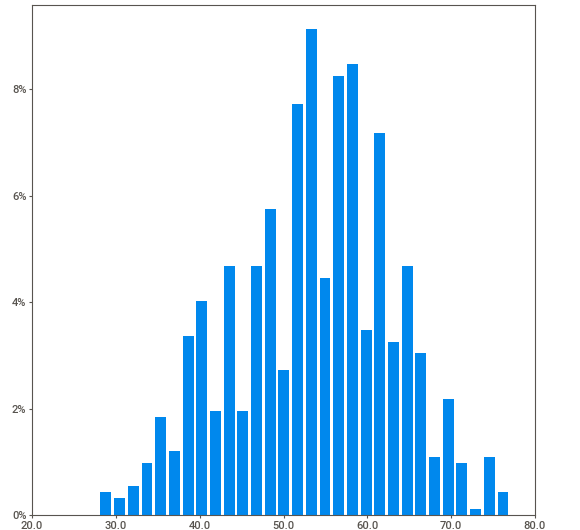
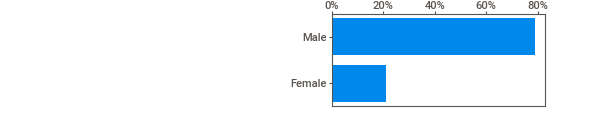
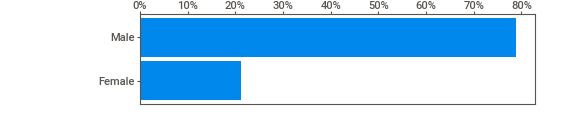
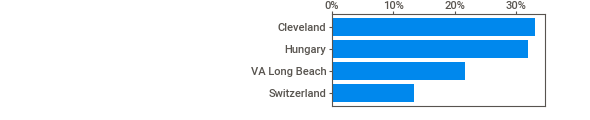
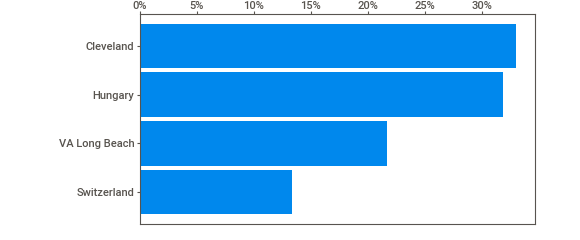
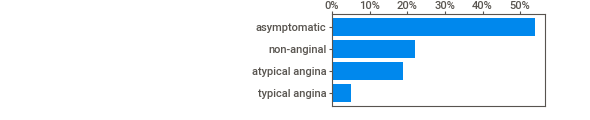
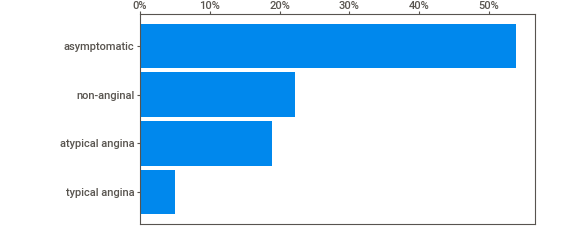
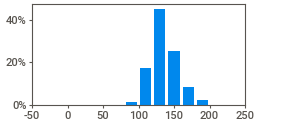
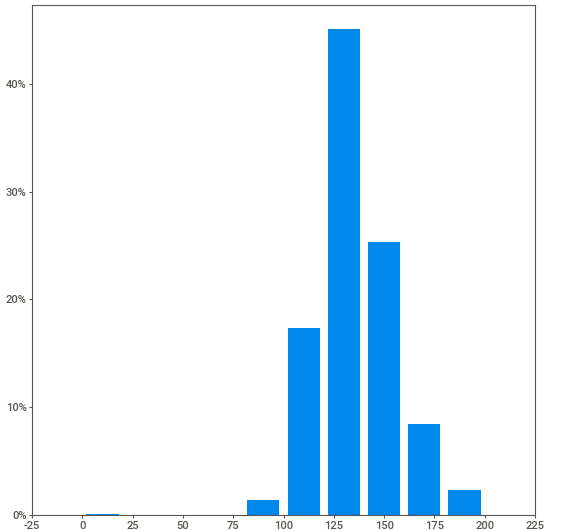
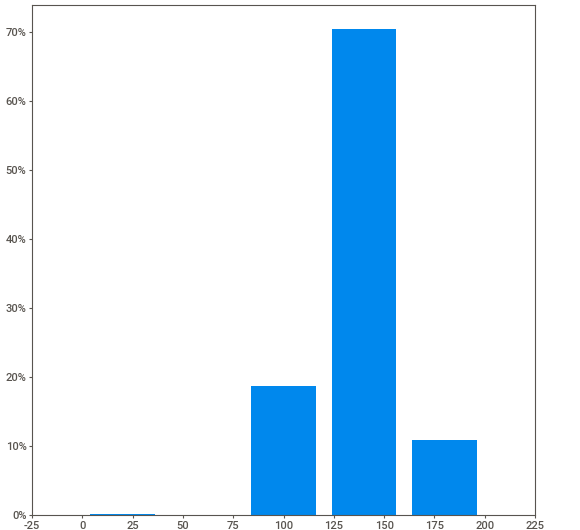
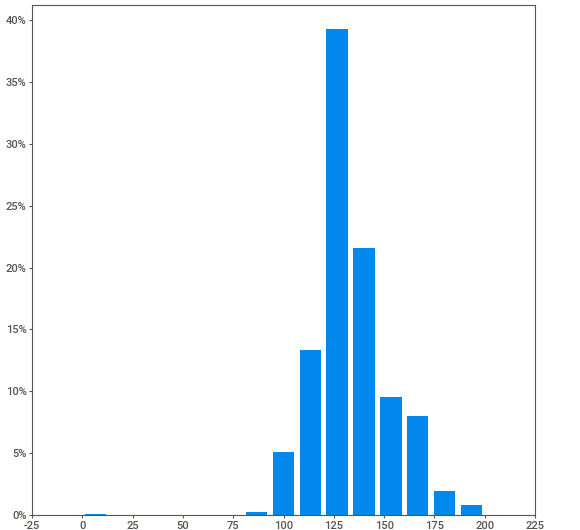
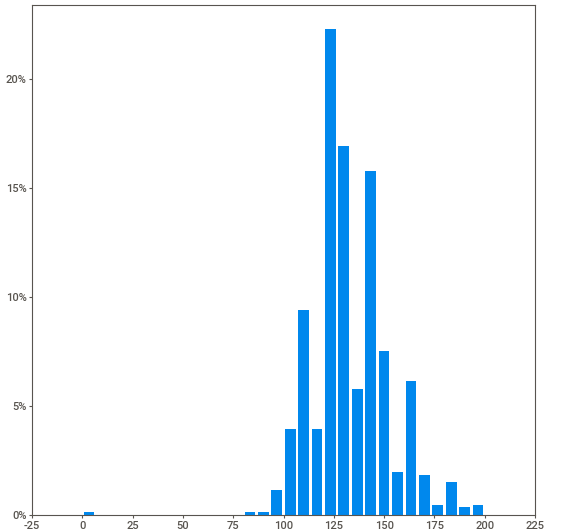
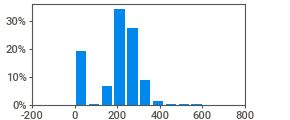
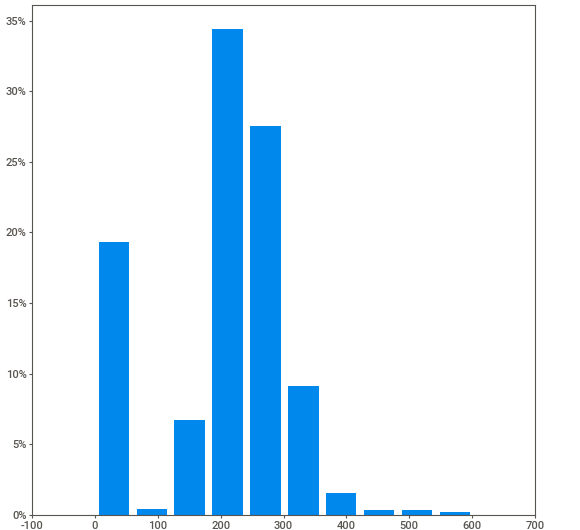
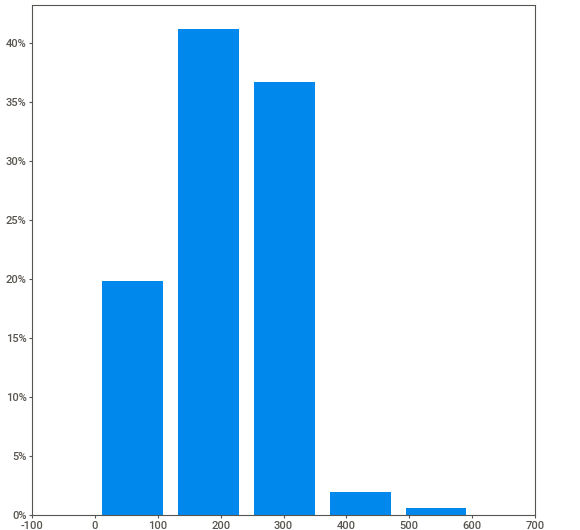
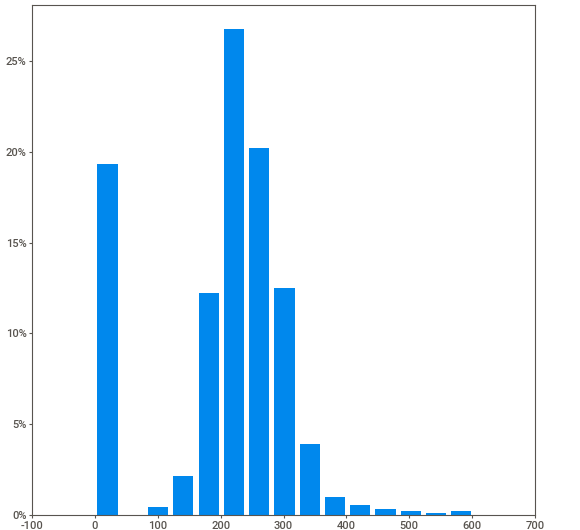
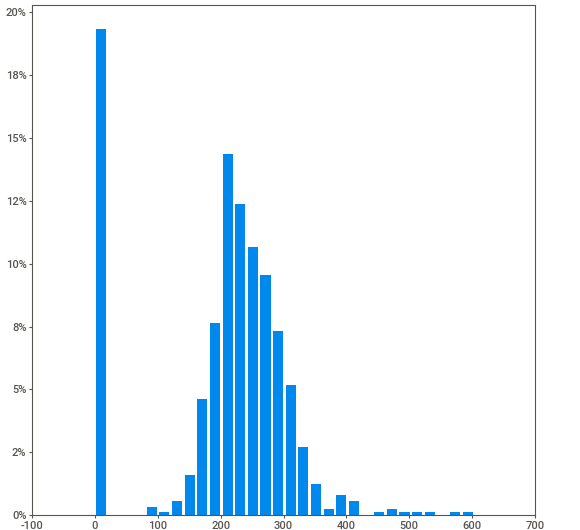
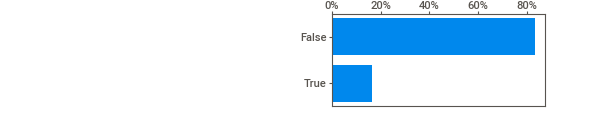
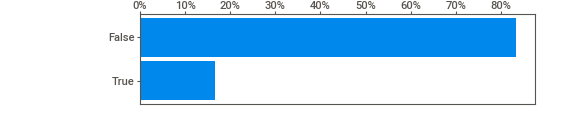
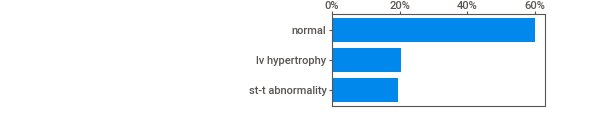
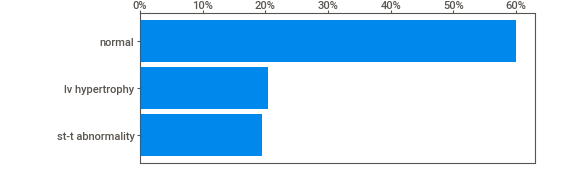
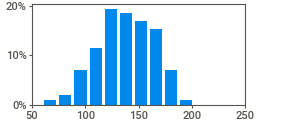
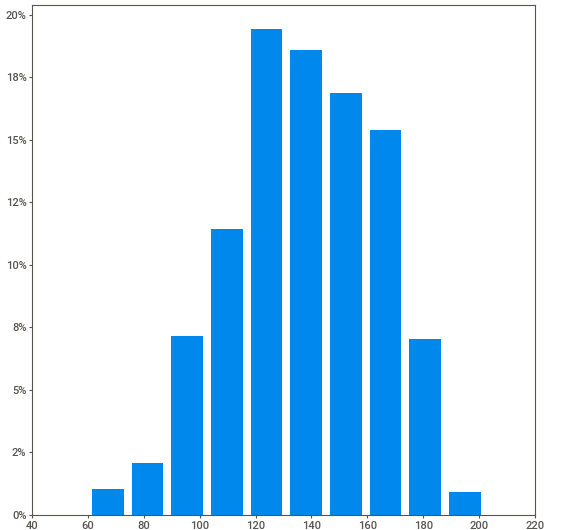
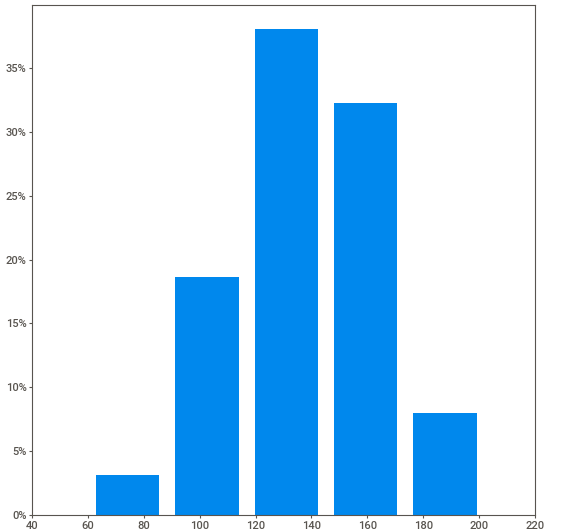
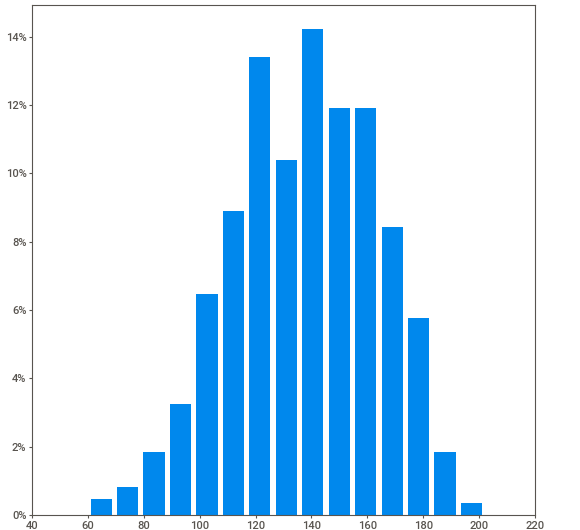
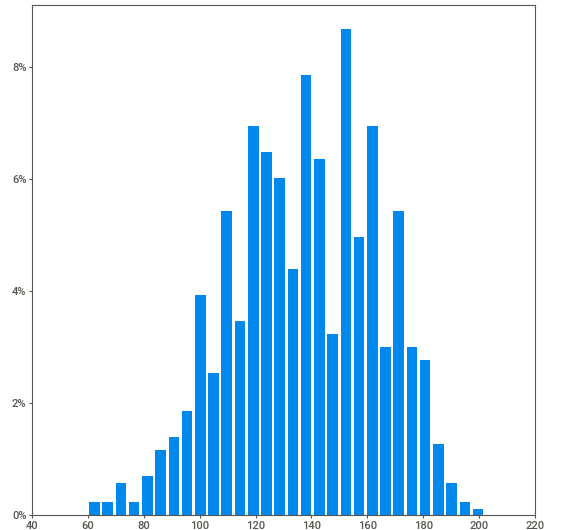
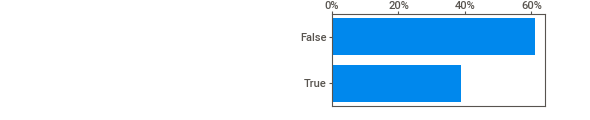
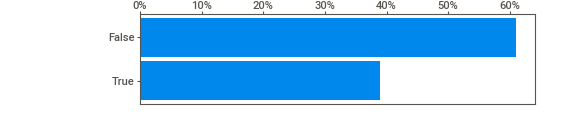
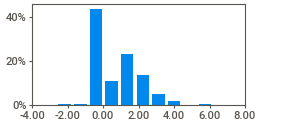
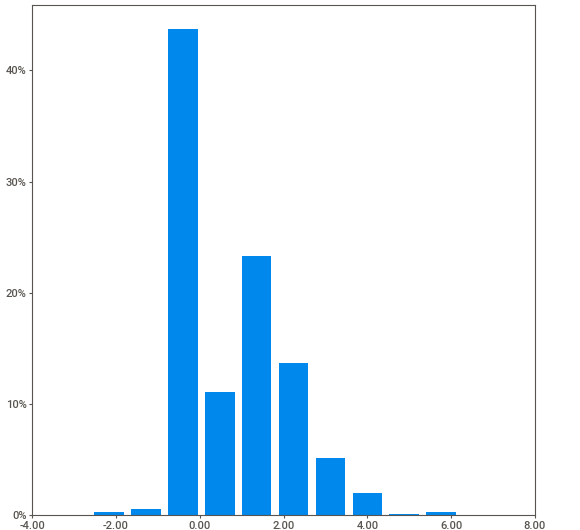
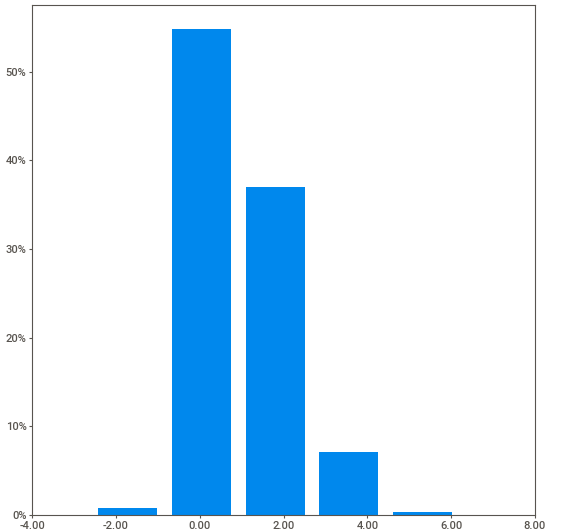
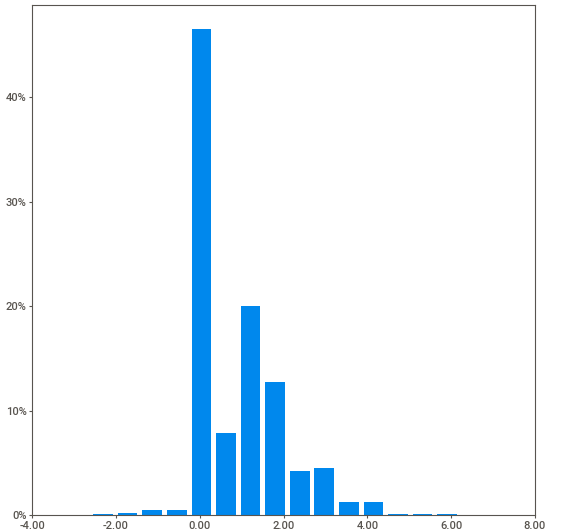
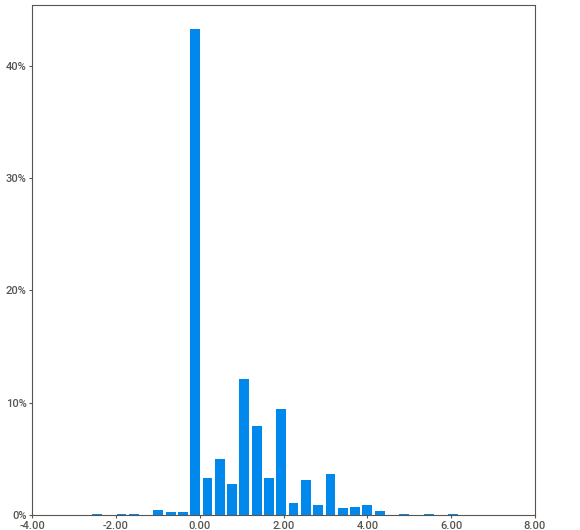
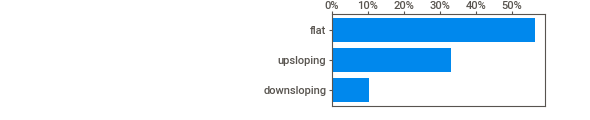
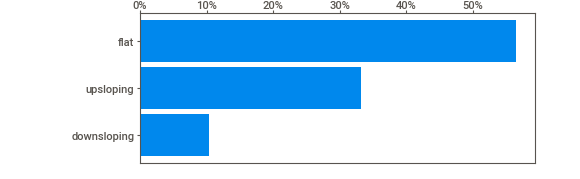
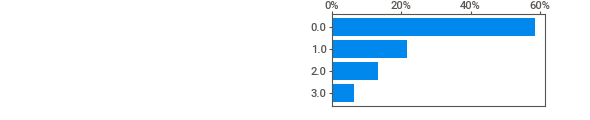
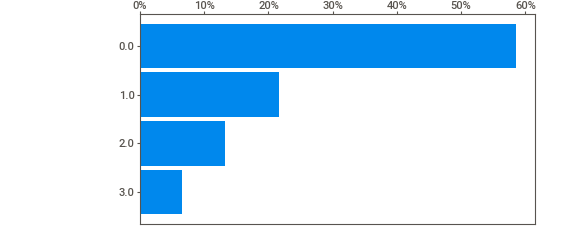
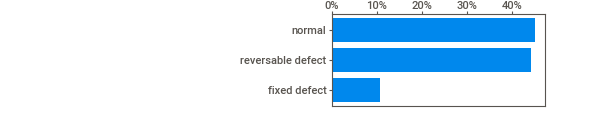
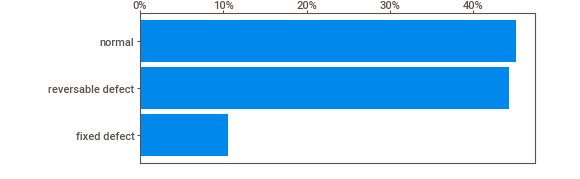
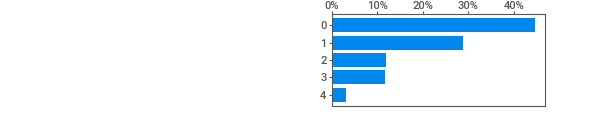
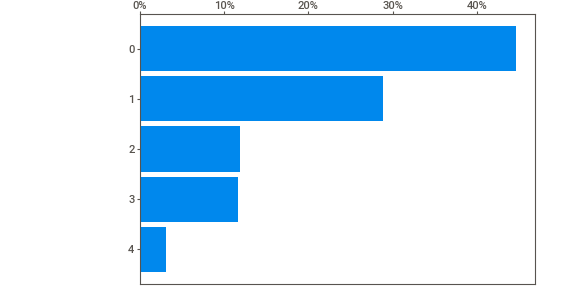
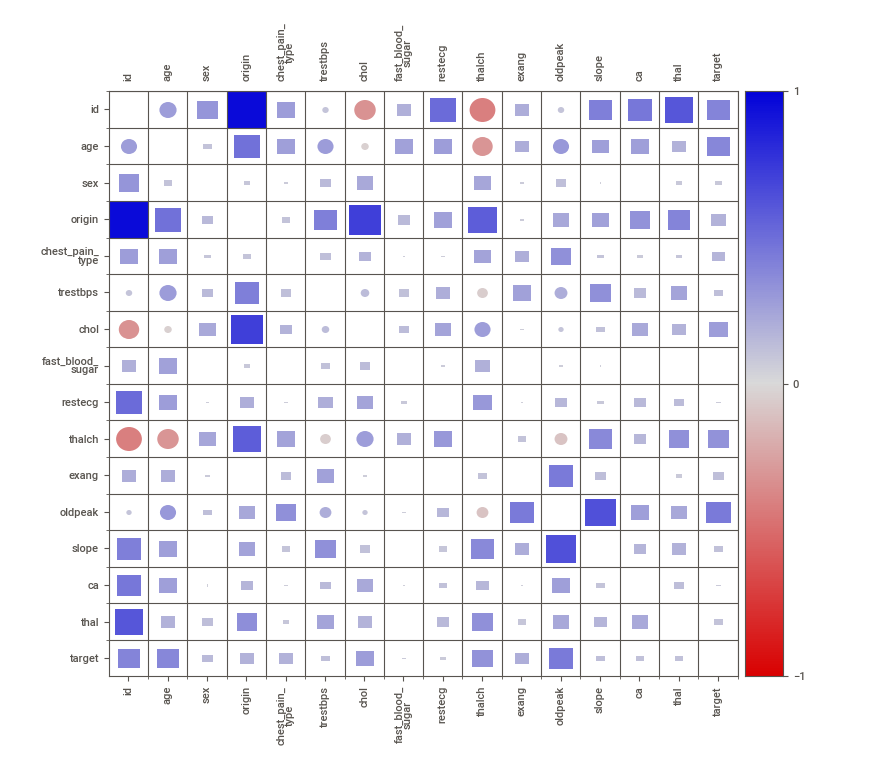
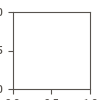

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                920 non-null    int64  
 1   age               920 non-null    int64  
 2   sex               920 non-null    object 
 3   origin            920 non-null    object 
 4   chest_pain_type   920 non-null    object 
 5   trestbps          861 non-null    float64
 6   chol              890 non-null    float64
 7   fast_blood_sugar  830 non-null    object 
 8   restecg           918 non-null    object 
 9   thalch            865 non-null    float64
 10  exang             865 non-null    object 
 11  oldpeak           858 non-null    float64
 12  slope             611 non-null    object 
 13  ca                309 non-null    float64
 14  thal              434 non-null    object 
 15  target            920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory us

In [43]:
df_eda = sv.analyze(heart)
df_eda.show_notebook()

heart.info()

**Deal with duplicates nd missing values**

In [44]:
# Set the option to opt into the future behavior
pd.set_option('future.no_silent_downcasting', True)

duplicates = heart[heart.duplicated()] #no duplicate #identify duplicate rows
print(duplicates)

# Check missing values
print("Percentage of missing values in each column:")
print(round(heart.isnull().sum() * 100 / len(heart), 2))

# Identify categorical, numerical, and boolean columns
categorical_cols = heart.select_dtypes(include=['object', 'category']).columns
numerical_cols = heart.select_dtypes(include=['number']).columns
boolean_cols = heart.select_dtypes(include=['bool']).columns

print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)
print("Boolean columns:", boolean_cols)

# Fill missing values in categorical columns with mode
for col in categorical_cols:
    if heart[col].isnull().sum() > 0:  
        mode = heart[col].mode()[0]  
        heart[col] = heart[col].fillna(mode)

# Fill missing values in numerical columns with mean
for col in numerical_cols:
    if heart[col].isnull().sum() > 0:  
        mean = heart[col].mean()  
        heart[col] = heart[col].fillna(mean)

# Fill missing values in boolean columns with mode
for col in boolean_cols:
    if heart[col].isnull().sum() > 0:  
        mode = heart[col].mode()[0]  
        heart[col] = heart[col].fillna(mode)

# Display missing values in a styled DataFrame
styled_missing = pd.DataFrame(heart.isnull().sum(), columns=['Missing Values']).T.style.background_gradient(cmap='Blues')
display(styled_missing)

Empty DataFrame
Columns: [id, age, sex, origin, chest_pain_type, trestbps, chol, fast_blood_sugar, restecg, thalch, exang, oldpeak, slope, ca, thal, target]
Index: []
Percentage of missing values in each column:
id                   0.00
age                  0.00
sex                  0.00
origin               0.00
chest_pain_type      0.00
trestbps             6.41
chol                 3.26
fast_blood_sugar     9.78
restecg              0.22
thalch               5.98
exang                5.98
oldpeak              6.74
slope               33.59
ca                  66.41
thal                52.83
target               0.00
dtype: float64
Categorical columns: Index(['sex', 'origin', 'chest_pain_type', 'fast_blood_sugar', 'restecg',
       'exang', 'slope', 'thal'],
      dtype='object')
Numerical columns: Index(['id', 'age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca', 'target'], dtype='object')
Boolean columns: Index([], dtype='object')


,id,age,sex,origin,chest_pain_type,trestbps,chol,fast_blood_sugar,restecg,thalch,exang,oldpeak,slope,ca,thal,target
Missing Values,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Deals With Catogorial and boolean Data (using label encoding method)**

In [45]:
#write me code to label boolen cols,  values as 1 for true and 0 for false, also for sex col write 0 for male and 1 female , 
# Initialize an empty dictionary to store the count of unique categories
unique_categories = {}

# Iterate over each categorical column to find the number of unique categories
for col in categorical_cols:
    unique_values = heart[col].unique()
    unique_count = len(unique_values)
    unique_categories[col] = unique_count

# Convert the dictionary to a DataFrame for better visualization
unique_categories_df = pd.DataFrame(list(unique_categories.items()), columns=['Column', 'Unique Categories'])

print(unique_categories_df)

boolean_cols = ['fast_blood_sugar', 'exang'] 
#converting boolean to int
for col in boolean_cols:
    heart[col] = heart[col].astype(int)
    
# Encode 'sex' column: 0 for male and 1 for female
heart['sex'] = heart['sex'].map({'Male': 0, 'Female': 1})

# Columns to be label encoded
columns_to_encode = ['origin', 'chest_pain_type', 'restecg', 'slope', 'thal']

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply Label Encoding to each column
for col in columns_to_encode:
    heart[col] = label_encoder.fit_transform(heart[col])

#verify
print(heart.head())
print(heart.info())


             Column  Unique Categories
0               sex                  2
1            origin                  4
2   chest_pain_type                  4
3  fast_blood_sugar                  2
4           restecg                  3
5             exang                  2
6             slope                  3
7              thal                  3
   id  age  sex  origin  chest_pain_type  trestbps   chol  fast_blood_sugar  \
0   1   63    0       0                3     145.0  233.0                 1   
1   2   67    0       0                0     160.0  286.0                 0   
2   3   67    0       0                0     120.0  229.0                 0   
3   4   37    0       0                2     130.0  250.0                 0   
4   5   41    1       0                1     130.0  204.0                 0   

   restecg  thalch  exang  oldpeak  slope   ca  thal  target  
0        0   150.0      0      2.3      0  0.0     0       0  
1        0   108.0      1      1.5      1  3.0  

**Dealing With Outliers**

In [ ]:
# Draw box plots for each numerical column
numerical_cols = heart.select_dtypes(include=['number']).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(5, 4, i)  # Adjust subplot configuration as needed
    sns.boxplot(y=heart[col])
    plt.title(col)
plt.tight_layout()
plt.show()

# Columns with potential outliers
columns_with_outliers = ['trestbps', 'chol', 'oldpeak']

# Function to remove outliers using the IQR method
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_out = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df_out

# Apply the function to each of the specified columns
for col in columns_with_outliers:
    heart = remove_outliers(heart, col)


In [47]:
# Separate features and target
X = heart.drop(columns='target')
y = heart['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict on the test set
y_pred = knn.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))



Accuracy: 0.6382978723404256
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.86      0.82        79
           1       0.46      0.43      0.44        37
           2       0.44      0.50      0.47         8
           3       0.25      0.15      0.19        13
           4       0.00      0.00      0.00         4

    accuracy                           0.64       141
   macro avg       0.39      0.39      0.38       141
weighted avg       0.61      0.64      0.62       141



**Find best value of K**

In [48]:
# Find the best k value and store accuracy for each k
accuracy_scores = []
k_values = range(1, 21)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

# Create a DataFrame to store k values and their corresponding accuracies
accuracy_df = pd.DataFrame({'k': k_values, 'accuracy': accuracy_scores})

# Display the DataFrame
print(accuracy_df)

# Find the best k value
best_k = k_values[np.argmax(accuracy_scores)]
print("Best k value:", best_k)

# Train the KNN model with the best k value
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

     k  accuracy
0    1  0.609929
1    2  0.638298
2    3  0.624113
3    4  0.602837
4    5  0.638298
5    6  0.652482
6    7  0.631206
7    8  0.645390
8    9  0.645390
9   10  0.645390
10  11  0.645390
11  12  0.652482
12  13  0.659574
13  14  0.638298
14  15  0.638298
15  16  0.645390
16  17  0.659574
17  18  0.645390
18  19  0.645390
19  20  0.638298
Best k value: 13


KNeighborsClassifier(n_neighbors=13)

**Evaluate model after apply choosing bestKvalue feature selection technique using greedy approach**
**Filter Methods**

**Correlation Coefficient**: Measures linear relationship between numerical features and target.

**Chi-square Test**: Assesses association between categorical features and categorical target.

**Mutual Information**: Quantifies information gain about target from features.


**Wrapper Methods:**


Recursive Feature Elimination (RFE): Iteratively removes features and evaluates model performance until the optimal number of features is reached.

Forward Selection: Starts with no features and adds them one by one, selecting the one that improves model performance the most at each step.

Backward Elimination: Starts with all features and removes the least significant feature at each step.

**Embedded Methods:**


Lasso (L1 Regularization): Penalizes the absolute size of coefficients, leading to sparse solutions where less important features have coefficients reduced to zero.(Linear Regression)
(Lasso (L1 Regularization) is typically used with linear models, such as Linear Regression or Logistic Regression, where it can directly influence the model’s coefficients to perform feature selection. However, since k-Nearest Neighbors (kNN) is a non-parametric model and doesn’t have coefficients in the traditional sense, Lasso cannot be applied directly to kNN.)


Decision Trees and Random Forest Feature Importance: Assess feature importance based on how much each feature improves the purity of the nodes in the trees.

**Filter Method and Accuracy:**

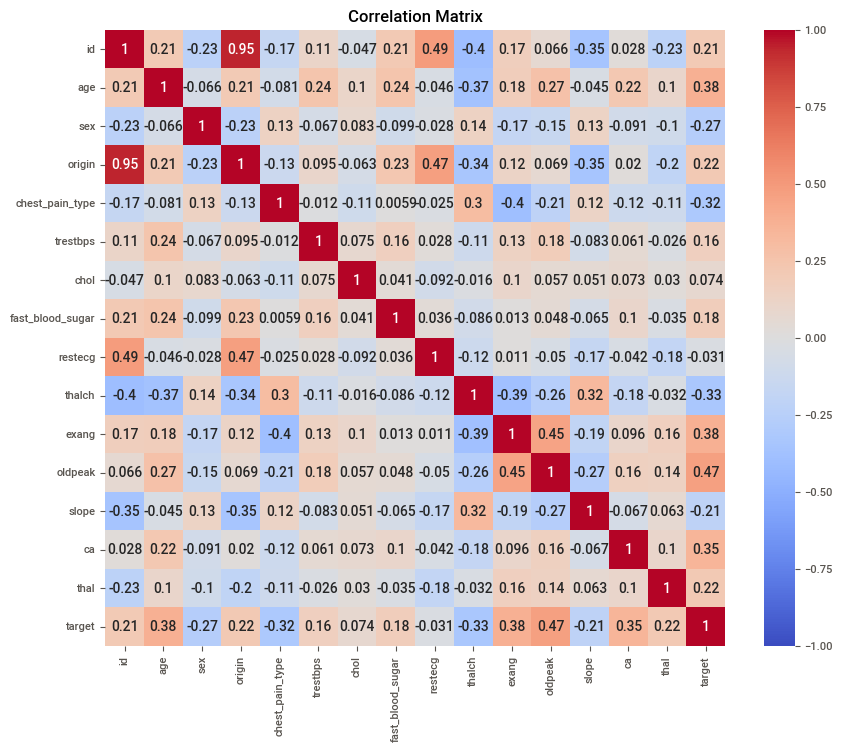


Selected Features based on Correlation:
['age', 'sex', 'chest_pain_type', 'thalch', 'exang', 'oldpeak', 'ca', 'target']

Accuracy: 0.8368794326241135
Precision: 0.8174980108330532
F1-score: 0.8249102530426407
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94        79
           1       0.83      0.78      0.81        37
           2       0.50      0.75      0.60         8
           3       0.64      0.54      0.58        13
           4       0.00      0.00      0.00         4

    accuracy                           0.84       141
   macro avg       0.58      0.61      0.59       141
weighted avg       0.82      0.84      0.82       141



In [49]:
#Filter Method
# Step 1: Calculate correlation matrix
correlation_matrix = heart.corr()

# Visualize the correlation matrix with colors
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

# Step 2: Filter features based on correlation threshold
threshold = 0.25  # Example threshold for correlation

# Create a mask to select features based on correlation
mask = np.abs(correlation_matrix["target"]) > threshold
selected_features = heart.columns[mask].tolist()


# Display selected features
print("\nSelected Features based on Correlation:")
print(selected_features)

# Separate features and target variable
X = heart[selected_features]
y = heart['target']

# Step 3: Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the KNN model
knn = KNeighborsClassifier(n_neighbors=5)  # Example k value
knn.fit(X_train, y_train)


# Predict on the test set
y_pred = knn.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy:", accuracy)

# Calculate precision and F1-score
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("Precision:", precision)
print("F1-score:", f1)

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))


**Recursive Feature Elimination (RFE) with KNN And Evaluation**

In [50]:
from sklearn.metrics import roc_auc_score

knn = KNeighborsClassifier(n_neighbors=5)
rfe = RFE(estimator=knn, n_features_to_select=10)
rfe.fit(X_train, y_train)
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)
knn.fit(X_train_rfe, y_train)
y_pred_rfe = knn.predict(X_test_rfe)
print("RFE + KNN Accuracy:", accuracy_score(y_test, y_pred_rfe))
print("RFE + KNN Precision:", precision_score(y_test, y_pred_rfe, average='macro', zero_division=1))
print("RFE + KNN Recall:", recall_score(y_test, y_pred_rfe, average='macro'))
print("RFE + KNN F1-Score:", f1_score(y_test, y_pred_rfe, average='macro'))
print("RFE + KNN ROC-AUC:", roc_auc_score(y_test, knn.predict_proba(X_test_rfe), multi_class='ovr'))

RFE + KNN Accuracy: 0.8368794326241135
RFE + KNN Precision: 0.7761195431074949
RFE + KNN Recall: 0.6068541277402038
RFE + KNN F1-Score: 0.5854320987654321
RFE + KNN ROC-AUC: 0.9290239326016969


Summary-Comparison

<Figure size 1400x800 with 0 Axes>

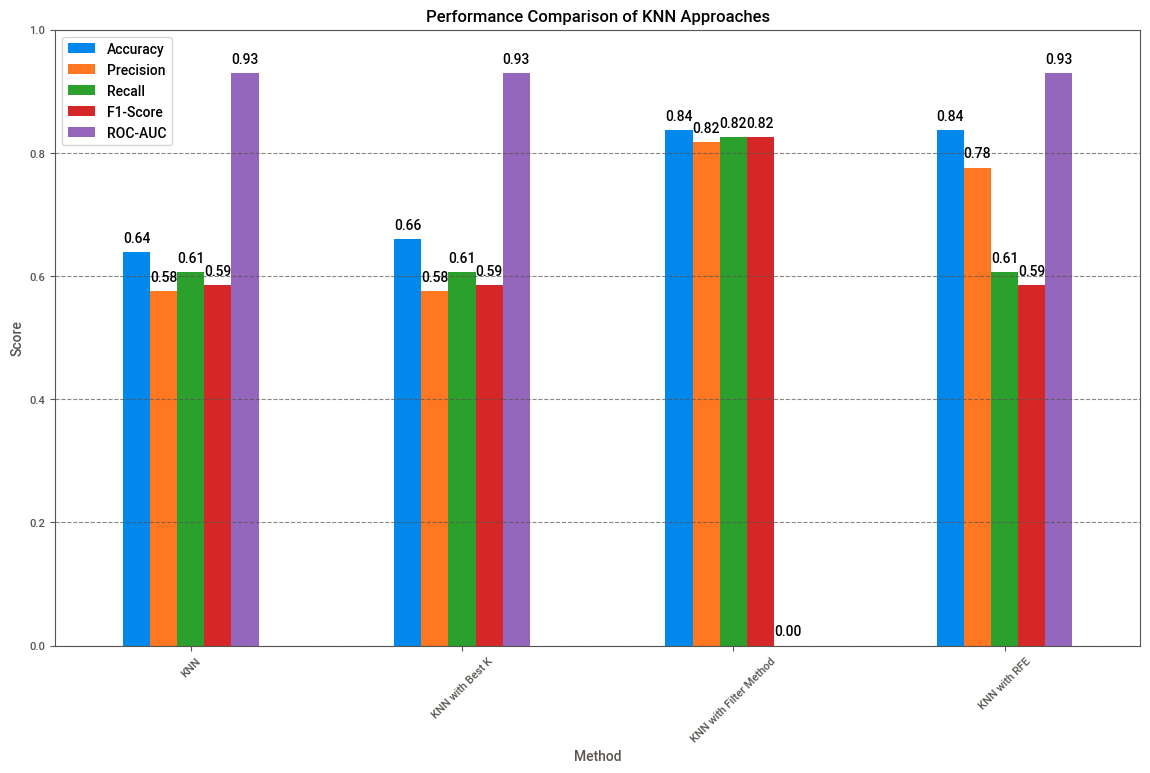

In [58]:
# Metrics for different approaches
metrics = {
    'KNN': {
        'Accuracy': 0.6382978723404256,
        'Precision': 0.5761195431074949,
        'Recall': 0.6068541277402038,
        'F1-Score': 0.5854320987654321,
        'ROC-AUC': 0.9290239326016969
    },
    'KNN with Best K': {
        'Accuracy': 0.6595744680851063,
        'Precision': 0.5761195431074949,
        'Recall': 0.6068541277402038,
        'F1-Score': 0.5854320987654321,
        'ROC-AUC': 0.9290239326016969
    },
    'KNN with Filter Method': {
        'Accuracy': 0.8368794326241135,
        'Precision': 0.8174980108330532,
        'Recall': 0.8249102530426407,
        'F1-Score': 0.8249102530426407,
        'ROC-AUC': np.nan  # ROC-AUC not calculated in this step
    },
    'KNN with RFE': {
        'Accuracy': 0.8368794326241135,
        'Precision': 0.7761195431074949,
        'Recall': 0.6068541277402038,
        'F1-Score': 0.5854320987654321,
        'ROC-AUC': 0.9290239326016969
    }
}

# Convert metrics to DataFrame for easy plotting
metrics_df = pd.DataFrame(metrics).T
metrics_df = metrics_df.reset_index().rename(columns={'index': 'Method'})

# Plotting
plt.figure(figsize=(14, 8))
metrics_df.set_index('Method').plot(kind='bar', figsize=(14, 8), rot=45)
plt.title('Performance Comparison of KNN Approaches')
plt.ylabel('Score')
plt.xlabel('Method')
plt.ylim(0, 1)  # Set y-axis limit to 1 for better comparison
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with exact values
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()


**Conclusions**

Feature Selection Impact: Both the filter method and RFE improved the model’s accuracy, showing that feature selection techniques are effective in enhancing model performance. The filter method provided a slight advantage in precision and recall compared to RFE.

Best Approach: The filter method yielded the highest accuracy, precision, recall, and F1-score, making it the most effective feature selection technique among those tested. RFE also performed well but with slightly lower precision and recall.

Model Performance: The KNN model with the best k value showed modest improvement over the base KNN model. Feature selection approaches provided more significant improvements compared to tuning k.

Recommendations
Continue Using Feature Selection: Based on the results, feature selection methods like correlation-based filtering or RFE should be preferred for improving KNN model performance.
Further Exploration: Consider exploring additional feature selection techniques and hyperparameter tuning to optimize the model further.
ROC-AUC: While ROC-AUC remained high across models, ensuring that this metric aligns with practical application needs is crucial.

Feature Selection Impact: Both the filter method and RFE improved the model’s accuracy, showing that feature selection techniques are effective in enhancing model performance. The filter method provided a slight advantage in precision and recall compared to RFE.

Best Approach: The filter method yielded the highest accuracy, precision, recall, and F1-score, making it the most effective feature selection technique among those tested. RFE also performed well but with slightly lower precision and recall.

Model Performance: The KNN model with the best k value showed modest improvement over the base KNN model. Feature selection approaches provided more significant improvements compared to tuning k.

Recommendations
Continue Using Feature Selection: Based on the results, feature selection methods like correlation-based filtering or RFE should be preferred for improving KNN model performance.
Further Exploration: Consider exploring additional feature selection techniques and hyperparameter tuning to optimize the model further.
ROC-AUC: While ROC-AUC remained high across models, ensuring that this metric aligns with practical application needs is crucial.